_Dependencies and library requirements_

In [1]:
# standard libraries
import numpy as np #numpy warnings, if any, may be safely ignored, known issue.
import pandas as pd
from collections import defaultdict
from math import * # Used for the haversine/distance calculations

# for visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# for model building
from sklearn.cluster import KMeans

# for optimizations
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

_Loading in station data by year. Hierarchal dataframe with levels based on year_

In [2]:
nr_dict = defaultdict()
for x in [2010 + x for x in range(8)] :
    nr_dict[x] = pd.read_csv("https://raw.githubusercontent.com/SethDKelly/NiceRideMN/master/Nice_Ride_data/" \
                             +str(x)+"/NiceRide_station_"+str(x)+".csv")
NR_station = pd.concat(nr_dict)

_Due to station distance matrices being different sizes current load pattern is by manual selection of year._

In [3]:
def find_center(df, clus):
    
    max_l = df[df['cluster'] == clus]['Longitude'].max()
    min_l = df[df['cluster'] == clus]['Longitude'].min()
    center_long = (max_l - min_l)/2 + min_l
    
    max_w = df[df['cluster'] == clus]['Latitude'].max()
    min_w = df[df['cluster'] == clus]['Latitude'].min()
    center_lat = (max_w - min_w)/2 + min_w
    
    return (center_long, center_lat)

In [4]:
def circle_radius(df,clus):
    
    long1, lat1 = find_center(df,clus)
    
    lat2 = df[df['cluster'] == clus]['Latitude'].max()
    long2 = df[df['cluster'] == clus]['Longitude'].max()
    
    diff_long = long2-long1
    diff_lat = lat2-lat1
    if diff_lat > diff_long:
        return diff_lat
    else:
        return diff_long

_Graphing of the clusters by Latitude (X) and Longitude (Y). Included is the code for creating circles of influence. A subject measure of the area of cover the clusters would have for intra/trans travel. The 'circle' is based on square center of the cluster determined by lat/long and a radius that's based on the larger difference between max or min lat/long._

In [15]:
def kmeans_builder(NR_station) :
    
    # For KMeans model building
    from sklearn.cluster import KMeans

    # For Feature Optimizations
    from sklearn.decomposition import PCA

    #########################################################################
    # This sections builds the clusters for each (2010-2017) years data
    # The code uses KMeans clustering with a K value of 6
    # Appends to the DF `NR_station` the cluster each station belongs to
    # into a new column `Cluster`
    ########################################################################

    NR_station['Cluster'] = int(0)

    k_val = 6
    
    for year in [2010 + x for x in range(8)] :
    
        distance_matrix = pd.DataFrame() # Reinstantiate the  Distance Matrix DataFrame for clean run
    
        # Read in the distance matrix for the particular year
        distance_matrix = pd.read_csv("https://raw.githubusercontent.com/SethDKelly/NiceRideMN/master/Nice_Ride_data/" \
                               +str(year)+"/distance_matrix_"+str(year)+".csv",index_col=0)
        
        # Optimize distance matrix to two primary x-y components
        pca = PCA(n_components=2).fit_transform(distance_matrix)
        
        # assert len(NR_station.loc[year, 'Cluster'].values) == 
        kmeans = KMeans(n_clusters=k_val, n_init=200).fit(pca)
        centers = kmeans.cluster_centers_

        for x in range(19) :
    
            # Reduce the dimensionality of our distance matrix
            kmeans = KMeans(n_clusters=k_val, n_init=100).fit(pca)
            centers += kmeans.cluster_centers_
            
            centered = centers / 20
            #Append to the DF `NR_station` the cluster each station belongs to in column `Cluster`
            NR_station.loc[year, 'Cluster'] =  KMeans(n_clusters=k_val, init=centered, n_init=10).fit(pca).labels_
        
    return NR_station

In [16]:
nr_station = kmeans_builder(NR_station)

/home/grimoire/anaconda3/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:896: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


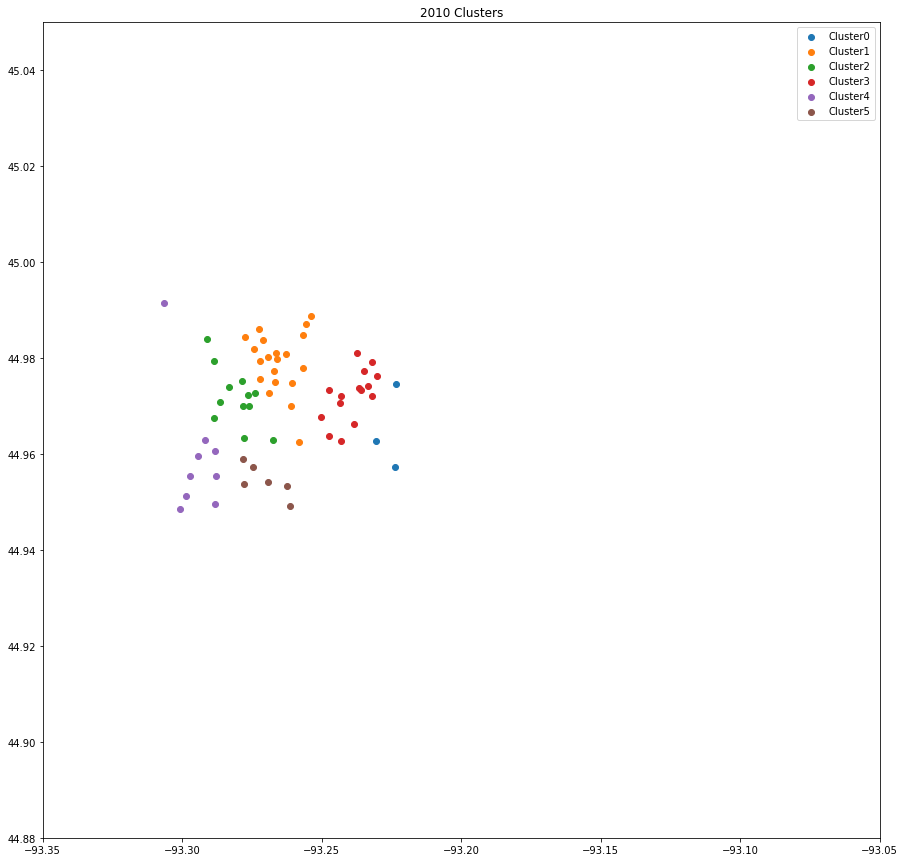

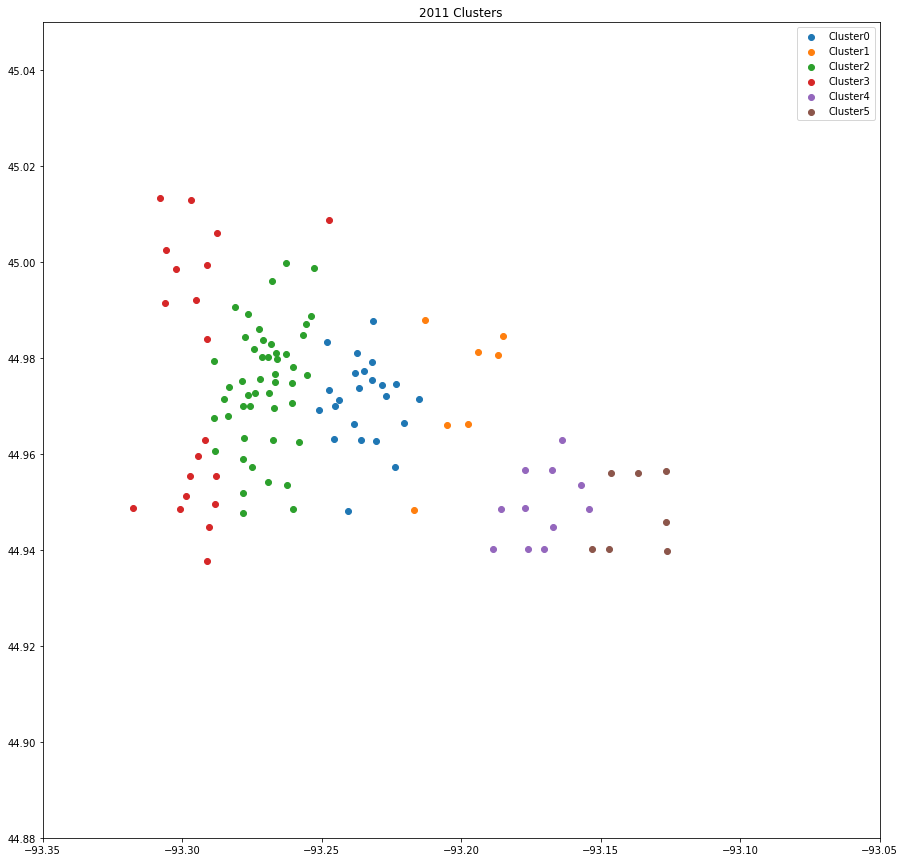

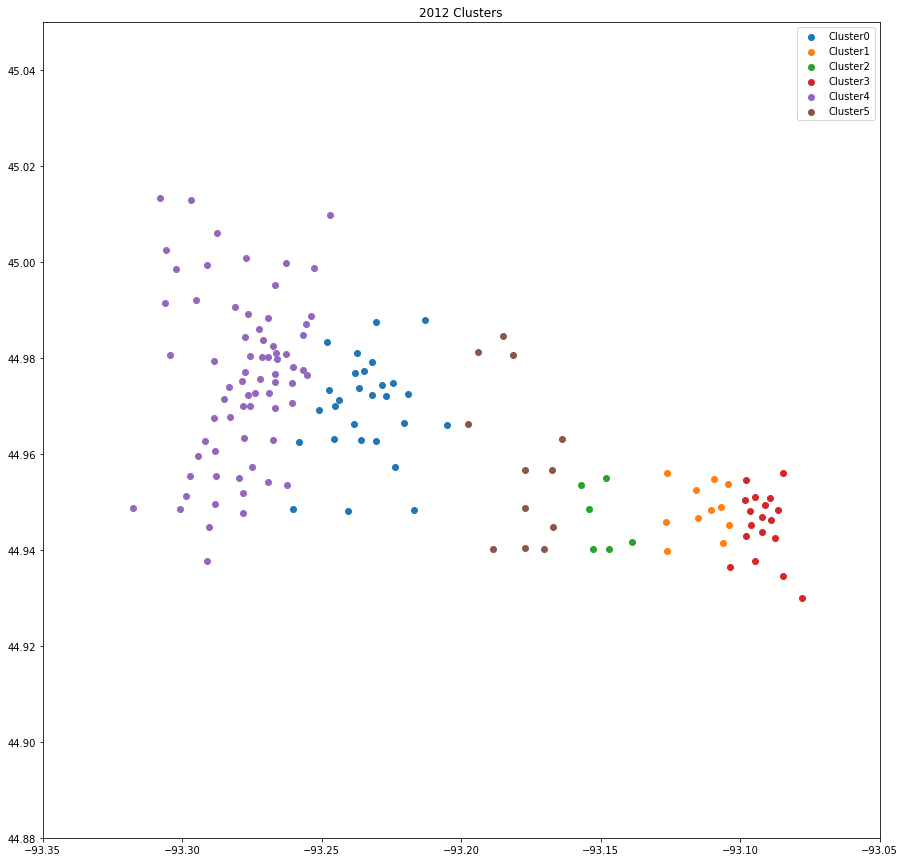

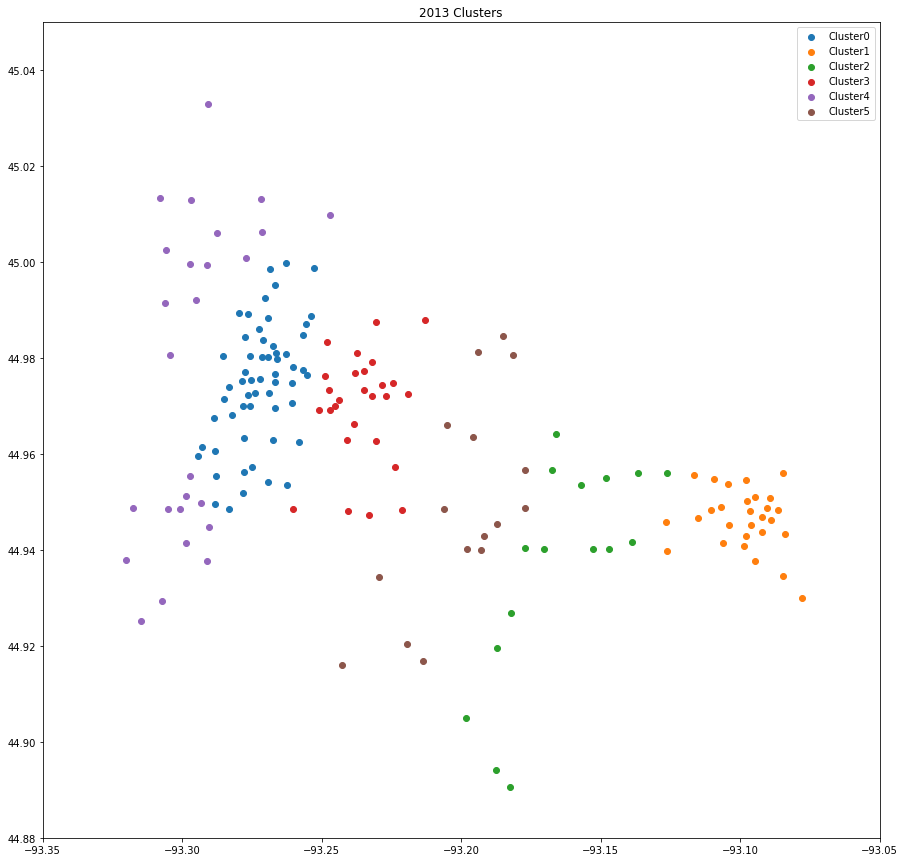

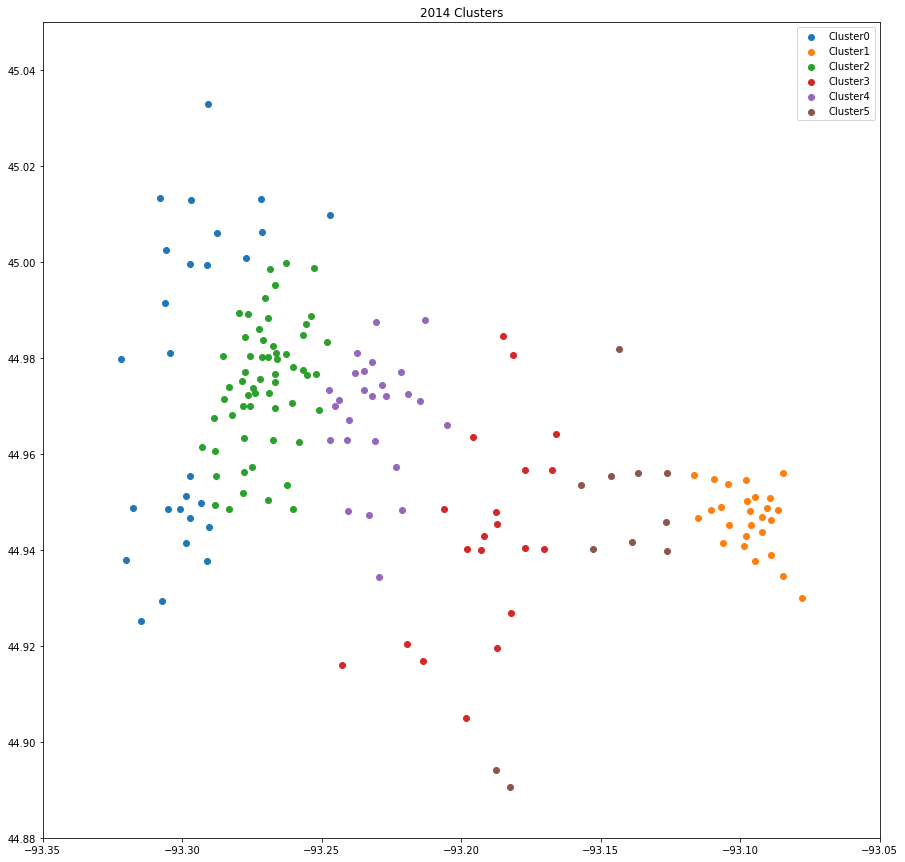

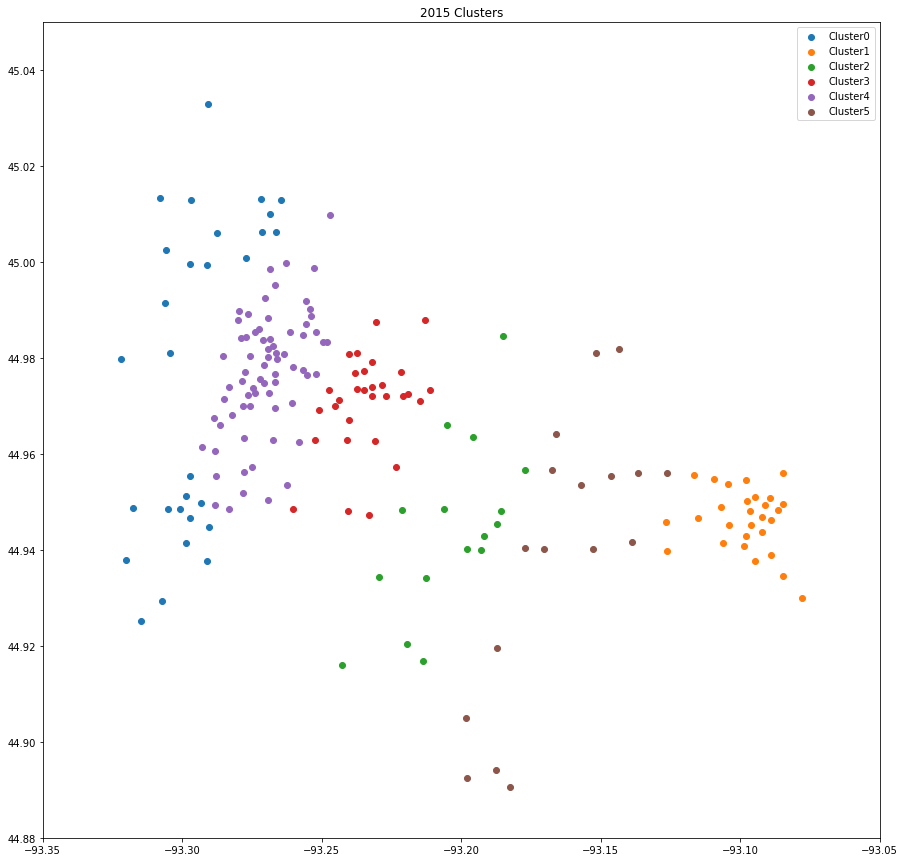

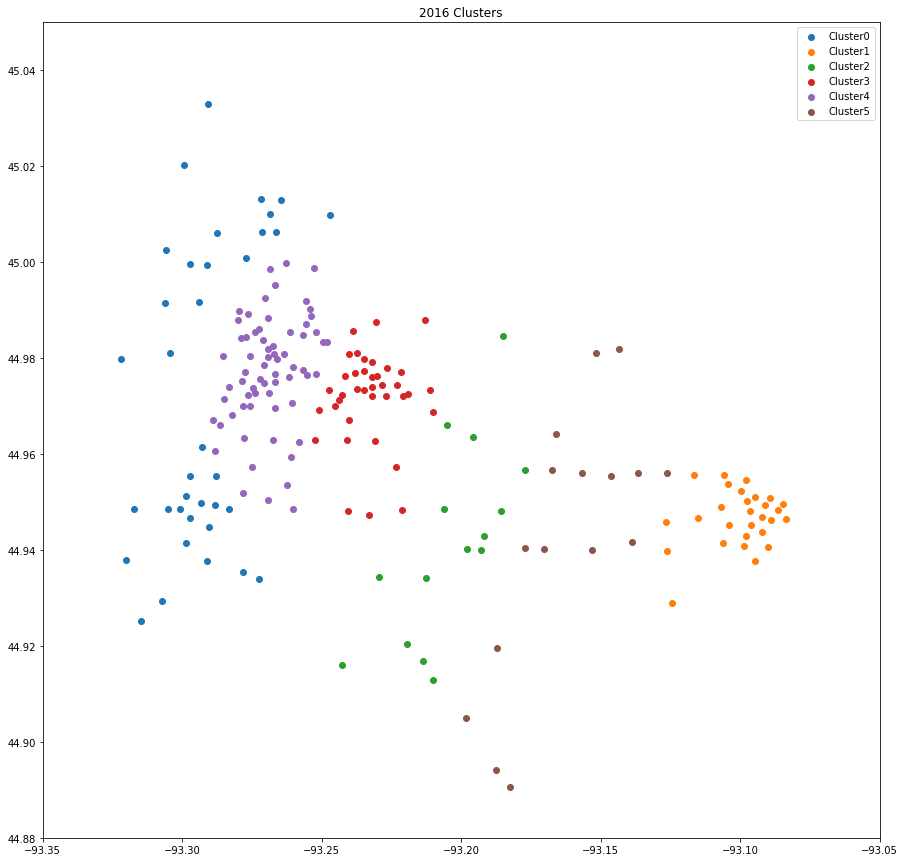

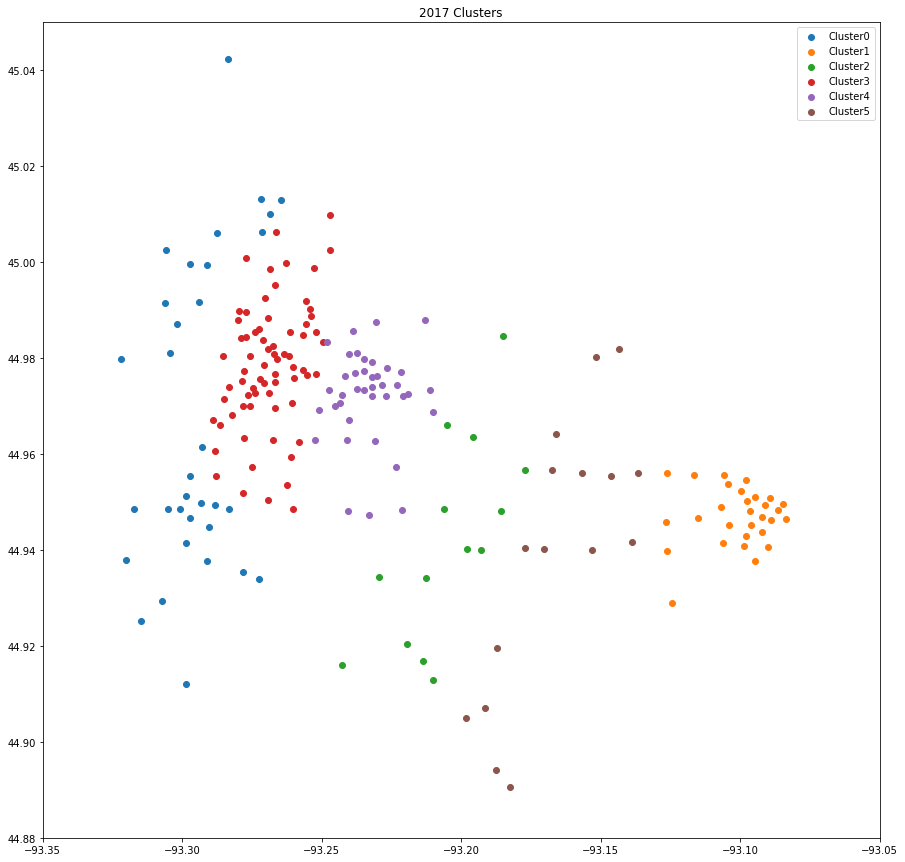

In [17]:
import matplotlib.pyplot as plt

for year in [2010 + x for x in range(8)] :

    plt.figure(figsize=[15,15])
    plt.xlim([-93.35,-93.05])
    plt.ylim([44.88,45.05])
    
    for k in range(0,6):
        temp = nr_station.loc[year, :][nr_station.loc[year, 'Cluster'] == k]
        ax = plt.scatter(temp.Longitude, temp.Latitude, label='Cluster'+str(k))
    
        ax = plt.gca()
        ax.set_title(str(year)+' Clusters')
        ax.legend()
    
    plt.savefig("/home/grimoire/Projects/NiceRide/Visualizations/Clusters/"+str(year)+"_clustering")
    plt.show()
    